In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/thanjavur-dataset-new/updated_dataset .csv


# WITHOUT FEATURE SELECTION 

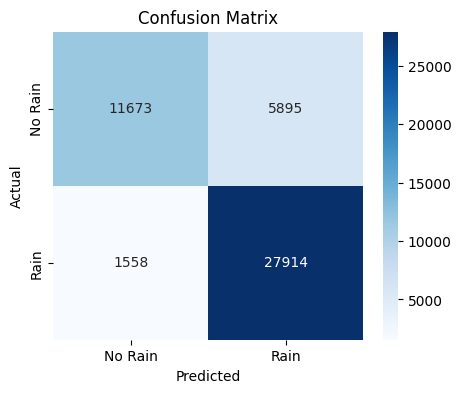

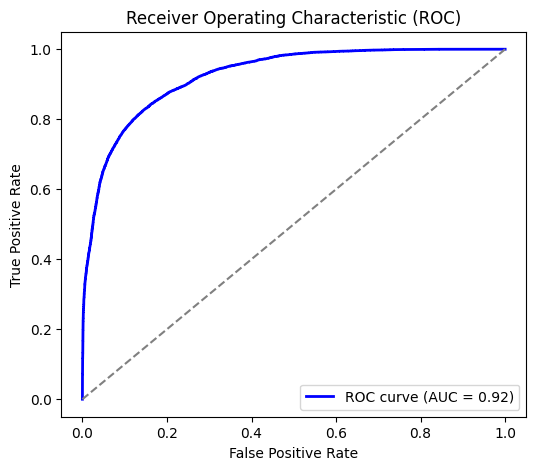

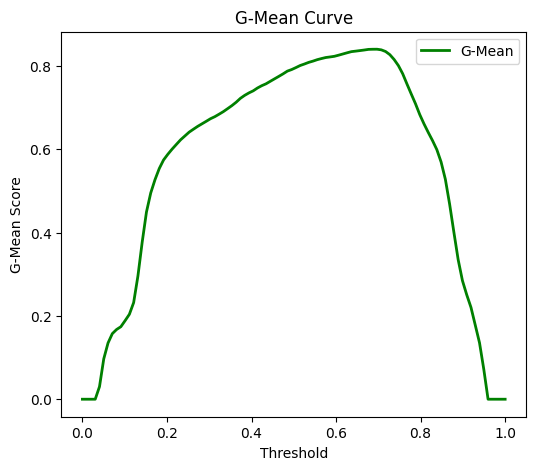


📊 Model Performance Metrics:
Accuracy: 0.8416
Precision: 0.8256
Recall: 0.9471
F1-Score: 0.8822
G-Mean: 0.7933


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, roc_curve, auc
)
from imblearn.metrics import geometric_mean_score

# ✅ Load dataset
df = pd.read_csv("/kaggle/input/thanjavur-dataset-new/updated_dataset .csv")  # Change to your dataset

# ✅ Remove Missing Values
df.dropna(inplace=True)

# ✅ Remove Outliers using IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# ✅ Define Features & Target
# 🔥 Remove highly correlated features (`T2MDEW`, `RainToday`) to avoid leakage
X = df.drop(columns=["RainTomorrow", "T2MDEW", "RainToday"])  
y = df["RainTomorrow"]

# ✅ Normalize Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Apply PCA (Retain 95% Variance)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# ✅ Train-Test Split (Stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

# ✅ Train Random Forest Model (Without Hyperparameter Tuning)
rf_model = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
rf_model.fit(X_train, y_train)

# ✅ Predictions
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

# ✅ Compute Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
g_mean = geometric_mean_score(y_test, y_pred)

# ✅ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Rain", "Rain"], yticklabels=["No Rain", "Rain"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ✅ ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()

# ✅ G-Mean Curve (Threshold Tuning)
thresholds = np.linspace(0, 1, 100)
g_means = []

for thresh in thresholds:
    y_thresh = (y_prob >= thresh).astype(int)
    g_means.append(geometric_mean_score(y_test, y_thresh))

plt.figure(figsize=(6, 5))
plt.plot(thresholds, g_means, color="green", lw=2, label="G-Mean")
plt.xlabel("Threshold")
plt.ylabel("G-Mean Score")
plt.title("G-Mean Curve")
plt.legend()
plt.show()

# ✅ Print Performance Metrics
print("\n📊 Model Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"G-Mean: {g_mean:.4f}")


# WITH FEATURE SELECTION 


🔍 Original Class Distribution:
RainTomorrow
1    147361
0     87838
Name: count, dtype: int64

🔥 Selected Features: ['MO', 'T2M', 'T2M_MIN', 'PRECTOTCORR', 'PS']


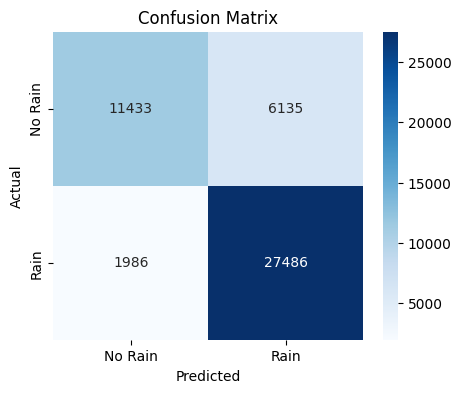

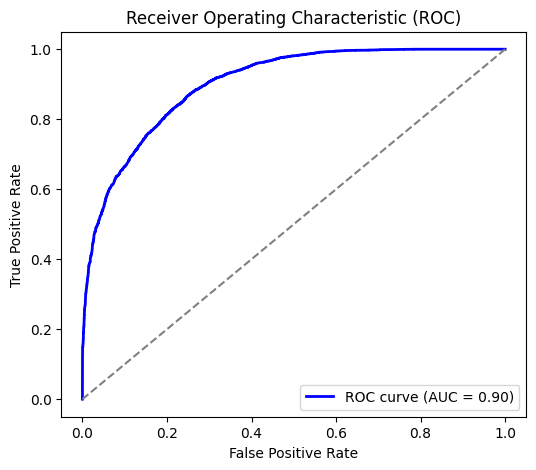

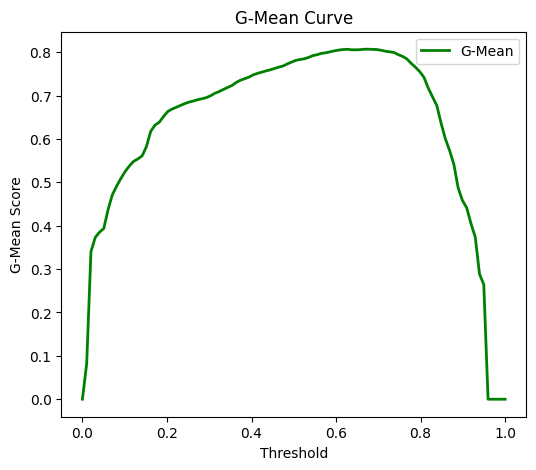


📊 Model Performance Metrics:
Accuracy: 0.8274
Precision: 0.8175
Recall: 0.9326
F1-Score: 0.8713
G-Mean: 0.7791

🔍 Feature Selection Scores:
         Feature         Score
5       T2M_MIN  73077.637249
7   PRECTOTCORR  40449.784895
3           T2M  19497.593616
1            MO  16540.964834
8            PS  14461.642644
6          RH2M   9303.660272
0          YEAR   3724.964497
9         WS10M   2249.231783
4       T2M_MAX    231.431336
10   Station_no     58.136137
2            DY     33.286628


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, roc_curve, auc
)
from imblearn.metrics import geometric_mean_score

# ✅ Load dataset
df = pd.read_csv('/kaggle/input/thanjavur-dataset-new/updated_dataset .csv')  # Change to your dataset

# ✅ Remove Missing Values
df.dropna(inplace=True)

# ✅ Remove Outliers using IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# ✅ Define Features & Target
# 🔥 Remove highly correlated features (`T2MDEW`, `RainToday`) to avoid leakage
X = df.drop(columns=["RainTomorrow", "T2MDEW", "RainToday"])  
y = df["RainTomorrow"]

# ✅ Print Class Distribution
print("\n🔍 Original Class Distribution:")
print(y.value_counts())

# ✅ Normalize Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Feature Selection: Select Top K Features
k = 5  # Choose the top 5 best features
selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(X_scaled, y)

# ✅ Get Selected Feature Names
selected_features = X.columns[selector.get_support()]
print("\n🔥 Selected Features:", list(selected_features))

# ✅ Train-Test Split (Stratified on y)
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# ✅ Train Random Forest Model (Without Hyperparameter Tuning)
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

# ✅ Predictions
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

# ✅ Compute Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
g_mean = geometric_mean_score(y_test, y_pred)

# ✅ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Rain", "Rain"], yticklabels=["No Rain", "Rain"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ✅ ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()

# ✅ G-Mean Curve (Threshold Tuning)
thresholds = np.linspace(0, 1, 100)
g_means = []

for thresh in thresholds:
    y_thresh = (y_prob >= thresh).astype(int)
    g_means.append(geometric_mean_score(y_test, y_thresh))

plt.figure(figsize=(6, 5))
plt.plot(thresholds, g_means, color="green", lw=2, label="G-Mean")
plt.xlabel("Threshold")
plt.ylabel("G-Mean Score")
plt.title("G-Mean Curve")
plt.legend()
plt.show()

# ✅ Print Performance Metrics
print("\n📊 Model Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"G-Mean: {g_mean:.4f}")

# ✅ Feature Scores
feature_scores = pd.DataFrame({"Feature": X.columns, "Score": selector.scores_})
feature_scores = feature_scores.sort_values(by="Score", ascending=False)
print("\n🔍 Feature Selection Scores:\n", feature_scores)
